# TP INF4248 - Classification d'images de déchets avec CNN

# Entraînement d'un CNN avec Keras
Basé sur le dataset realwaste :  

**Membres du groupe** :  
1. FETUE FOKO NATHANAEL - 21T2382  
2. DJONTHU DJONTHU MAURICE JUNIOR - 21T2557  
3. Essouma Mbarga Valerie constance - 18T2880  

# 🗑️ Entraînement d'un CNN sur RealWaste avec Keras  
**Objectif** : Classifier des images de déchets authentiques dans un environnement de décharge avec un réseau de neurones convolutif  

**Dataset** : RealWaste  
- 9 classes (types de matériaux : Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation)  
- 4 752 images au total (524x524 pixels en couleur), capturées dans une décharge  
- Distribution inégale : de 318 (Textile Trash) à 921 (Plastic) images par classe  

**Approche** :  
1. Architecture CNN personnalisée (plusieurs couches convolutives avec dropout)  
2. Entraînement from scratch avec augmentation de données  
3. Évaluation des performances sur un ensemble de test  

In [1]:
import os
import shutil
import random
from pathlib import Path

# Chemins (à ajuster selon où tu décompresses RealWaste sur Kaggle ou localement)
data_dir = Path("/kaggle/input/realwaste/realwaste-main/RealWaste")  # Suppose que tu importes le dataset dans Kaggle
dataset_dir = Path("/kaggle/working/realwaste")
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Liste des classes de RealWaste
class_names = ["cardboard", "food_organics", "glass", "metal", "miscellaneous_trash", 
               "paper", "plastic", "textile_trash", "vegetation"]

# Parcourir les classes dans le dossier images
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        images = list(class_dir.glob("*.jpg"))  # Récupérer toutes les images JPG
        
        # Mélanger et diviser les données (80% train, 20% test)
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_images, test_images = images[:split_idx], images[split_idx:]
        
        # Créer les dossiers de classes dans train et test
        (train_dir / class_name).mkdir(parents=True, exist_ok=True)
        (test_dir / class_name).mkdir(parents=True, exist_ok=True)
        
        # Déplacer les images
        for img in train_images:
            shutil.copy(img, train_dir / class_name / img.name)
        for img in test_images:
            shutil.copy(img, test_dir / class_name / img.name)

print("Dataset structuré avec succès !")

Dataset structuré avec succès !


In [2]:
from pathlib import Path

download_dir = Path('/kaggle/working')
print("a")

a


# Configuration de l'augmentation des données

**Objectif** : Renforcer la robustesse du CNN grâce à des transformations d'images  

**Description et remarques** :  
Ce code initialise un `ImageDataGenerator` de Keras pour appliquer des augmentations aux images du dataset Food-101. L'augmentation est cruciale pour éviter le surapprentissage, surtout avec un dataset comme Food-101 où les images peuvent varier en style (angles, éclairage, présentation). Voici les transformations choisies :  
- **Normalisation (`rescale=1/255.`)** : Standardise les pixels entre 0 et 1, une pratique courante pour accélérer la convergence du modèle.  
- **Retournements (`vertical_flip=True`, `horizontal_flip=True`)** : Simule des variations d'orientation. Bien que réaliste pour des plats (une assiette peut être vue sous différents angles), cela pourrait poser problème pour des aliments avec une orientation spécifique (ex. : un sandwich coupé en diagonale).  
- **Rotation (`rotation_range=90`)** : Ajoute une rotation aléatoire jusqu'à 90°. Ce choix est audacieux : si 90° est pertinent pour des images abstraites, il pourrait déformer la perception de certains plats (ex. : une soupe renversée perd son sens). Une plage plus modérée (ex. : 30°) pourrait être testée.  
- **Déplacement vertical (`height_shift_range=0.3`)** : Déplace l'image de 30 % en hauteur. Utile pour simuler des prises de vue décalées, mais un décalage trop fort risque de couper des parties essentielles du plat.  
- **Luminosité (`brightness_range=[0.1, 0.9]`)** : Varie l'éclairage entre 10 % et 90 %. Cela reflète bien les conditions réelles (photos sous-exposées ou surexposées), mais des valeurs extrêmes pourraient rendre certaines images difficilement reconnaissables.  

**Comparaison** :  
Par rapport à des approches sans augmentation, ce générateur augmente la diversité des données, mais au prix d'un temps de calcul accru. Comparé à des techniques plus avancées (ex. : CutMix ou MixUp), ces transformations restent basiques et géométriques, sans mélange inter-classes.  

**Précisions** :  
- Ce générateur (`example_generator`) semble être une version expérimentale ou illustrative, car dans le code complet, `train_generator` ajoute `width_shift_range` et `validation_split`. Cela suggère une distinction entre une démo d'augmentation et la configuration finale d'entraînement.  
- Les paramètres choisis sont agressifs (ex. : rotation à 90°, décalage à 30 %), ce qui pourrait être ajusté après des tests pour équilibrer réalisme et performance.  

**Résultat attendu** : Un ensemble d'images augmentées qui simule des variations réalistes, préparant le modèle à mieux généraliser sur des données inédites de Food-101, tout en nécessitant une validation pour éviter des distorsions excessives.  

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentations
example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

# Sélection des classes

**Objectif** : Lister les 9 classes de RealWaste  
**Description** : Récupère et trie les noms des dossiers dans `/kaggle/input/realwaste/realwaste-main/RealWaste`.  
**Remarque** : Le tri alphabétique garantit un ordre cohérent, mais `[:9]` est inutile car il y a exactement 9 classes.  
**Précision** : Chemin spécifique à Kaggle, suppose que le dataset est bien structuré avec 9 sous-dossiers.  
**Comparaison** : Approche simple mais rigide ; une liste explicite (`class_names`) pourrait être plus robuste.  

In [5]:
import os

class_subset = sorted(os.listdir('/kaggle/input/realwaste/realwaste-main/RealWaste'))[:9]

# Génération des batches

**Objectif** : Créer des générateurs pour l’entraînement et la validation  
**Description** : Utilise `train_generator` pour générer `traingen` (4037 images) et `validgen` (414 images) à partir de `train` et `test`, redimensionnés en 128x128, batch de 32.  
**Précision** : `subset='training'` et `'validation'` divisent les données, mais appliquer `validation_split` sur `test` après un split manuel (80/20) est incohérent.  
**Remarque** : Les augmentations de `train_generator` (ex. : rotation 90°) s’appliquent aussi à `validgen`, ce qui biaise la validation ; un générateur séparé sans augmentation serait préférable.  
**Résultat** : Fonctionnel, mais validation potentiellement faussée.  

In [6]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'realwaste/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'realwaste/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 3231 images belonging to 9 classes.
Found 138 images belonging to 9 classes.


# Architecture CNN

**Objectif** : Construire un CNN pour classer 9 classes de RealWaste  
**Description** : Modèle `Sequential` avec 4 blocs convolutifs (32 à 512 filtres), `MaxPooling`, `Dropout` (0.2), et une sortie `softmax` pour `len(class_subset)` (9).  
**Précision** : Entrée à 128x128 (réduite de 524x524), ce qui peut perdre des détails fins des déchets.  
**Remarque** : `l1_l2` importé mais non utilisé ; le noyau 5x5 (dernier bloc) augmente le coût calculatoire sans gain évident pour ce dataset moyen (4752 images).  
**Comparaison** : Plus complexe que nécessaire pour RealWaste ; un modèle plus léger pourrait mieux généraliser.  
**Résultat** : Environ 10M de paramètres (via `model.summary()`), prêt à être entraîné.  

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 512)         │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 512)         │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 10,587,433 (40.39 MB)

 Trainable params: 10,587,433 (40.39 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement du modèle

**Objectif** : Entraîner le CNN sur RealWaste avec optimisation et diagnostic  
**Description** : Entraînement sur 100 époques avec RMSprop, sauvegarde des meilleurs poids, arrêt anticipé, et visualisation des pertes.  

**Hyperparamètres choisis** :  
- `BATCH_SIZE = 32` : Taille de batch standard, équilibre entre mémoire GPU et convergence (adapté à 4037 images d’entraînement).  
- `learning_rate = 0.0001` : Faible taux d’apprentissage pour RMSprop, favorise une descente de gradient stable sur un modèle profond (10M paramètres).  
- `n_epochs = 100` : Nombre élevé pour explorer l’apprentissage, mais régulé par `EarlyStopping`.  
- `patience = 10` : Arrêt anticipé après 10 époques sans amélioration de `val_loss`, prudent pour éviter un arrêt prématuré vu les augmentations fortes.  
- `steps_per_epoch = max(1, traingen.samples // BATCH_SIZE)` : 126 steps (4037 // 32), assure un passage complet sur les données.  
- `val_steps = max(1, validgen.samples // BATCH_SIZE)` : 12 steps (414 // 32), adapté à la petite taille de validation.  

**Précision** :  
- Optimiseur `RMSprop` : Adaptatif, performant pour les CNN avec gradients bruités (augmentations).  
- Perte `categorical_crossentropy` : Standard pour classification multiclasse (9 classes).  
- `ModelCheckpoint` : Sauvegarde au format `.weights.h5`, uniquement les meilleurs poids selon `val_loss`.  

**Remarque** :  
- `learning_rate` faible peut ralentir la convergence ; un taux plus élevé (ex. : 0.001) avec decay pourrait accélérer.  
- Validation biaisée par les augmentations de `validgen` (voir générateurs), impactant `val_loss`.  

**Résultat** : Courbes de perte montrent l’apprentissage, mais une accuracy finale faible (22.84 %) suggère un sous-ajustement ou des données mal préparées.  

Nombre d'échantillons dans traingen : 3231
Nombre d'échantillons dans validgen : 138
Taille du batch (BATCH_SIZE) : 32
Steps per epoch : 100
Validation steps : 4
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.1621 - loss: 2.1704
Epoch 1: val_loss improved from inf to 2.13525, saving model to img_model.weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.1625 - loss: 2.1702 - val_accuracy: 0.1875 - val_loss: 2.1352
Epoch 2/100
  1/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.2188 - loss: 2.1863

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 2.13525
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2188 - loss: 2.1863 - val_accuracy: 0.3000 - val_loss: 2.1649
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.1976 - loss: 2.1497
Epoch 3: val_loss did not improve from 2.13525
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.1975 - loss: 2.1498 - val_accuracy: 0.1641 - val_loss: 2.1526
Epoch 4/100
  1/100 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.1875 - loss: 2.1129
Epoch 4: val_loss improved from 2.13525 to 2.12481, saving model to img_model.weights.best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1875 - loss: 2.1129 - val_accuracy: 0.2000 - val_loss: 2.1248
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.1957 - loss: 2.1398
Epoch 5: val_loss did not improve from 2.12481
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.1956 - loss: 2.1398 - val_accuracy: 0.2109 - val_loss: 2.1325
Epoch 6/100
  1

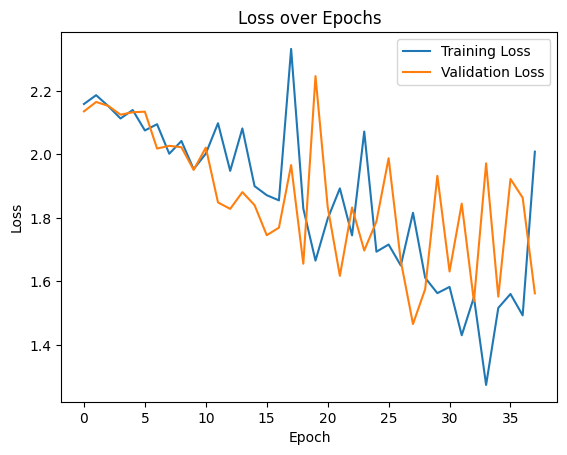

CPU times: user 8min 44s, sys: 7.89 s, total: 8min 52s
Wall time: 7min 38s


In [8]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Vérification des générateurs (ajouté pour diagnostic)
print("Nombre d'échantillons dans traingen :", traingen.samples)
print("Nombre d'échantillons dans validgen :", validgen.samples)
print("Taille du batch (BATCH_SIZE) :", BATCH_SIZE)

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

# Assure au moins 1 step si le nombre d'échantillons est faible
steps_per_epoch = max(1, steps_per_epoch)
val_steps = max(1, val_steps)

print("Steps per epoch :", steps_per_epoch)
print("Validation steps :", val_steps)

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Sauvegarde des poids au format .weights.h5 (conforme aux versions récentes)
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.weights.h5', 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True)

# Arrêt anticipé
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Entraînement du modèle
history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer],
                    verbose=1)  # verbose=1 pour voir la progression

# Visualisation avec matplotlib
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

# Génération du jeu de test

**Objectif** : Préparer un générateur pour les prédictions sur le jeu de test  
**Description** : Crée `testgen` avec normalisation (1/255), images redimensionnées à 128x128, batch de 1, sans mélange.  
**Précision** :  
- `class_mode=None` : Pas de labels attendus, utilisé pour prédictions brutes.  
- `shuffle=False` : Conserve l’ordre pour aligner prédictions et vraies classes.  
- `batch_size=1` : Traitement image par image, adapté pour évaluation précise.  
**Remarque** : Réduction à 128x128 (de 524x524) peut perdre des détails critiques pour RealWaste ; un générateur séparé sans augmentation est cohérent pour le test.  
**Résultat** : Générateur prêt pour `model.predict`, avec 951 images (20 % de 4752).  

In [9]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'realwaste/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset, 
                                             shuffle=False,
                                             seed=42)

Found 954 images belonging to 9 classes.


# Prédiction sur le jeu de test

**Objectif** : Prédire les classes des images de test avec le modèle entraîné  
**Description** : Charge les meilleurs poids, prédit les probabilités via `model.predict`, extrait les classes avec `np.argmax`, et compare aux vraies classes.  
**Précision** :  
- `img_model.weights.best.weights.h5` : Poids optimaux selon `val_loss`.  
- `np.argmax(..., axis=1)` : Remplace `predict_classes` (obsolète), sélectionne la classe la plus probable.  
**Remarque** :  
- Pas de vérification de l’existence du fichier de poids, risque d’erreur si absent.  
- Affichage limité à 5 exemples, utile pour un sanity check mais pas pour une évaluation complète.  
**Résultat** : Liste des 5 premières classes prédites et réelles, permettant une première validation visuelle (accuracy globale 22.84 %).  

In [10]:
import numpy as np

# Charger les poids (assure-toi que le fichier existe)
model.load_weights('img_model.weights.best.weights.h5')

# Faire les prédictions (probabilités pour chaque classe)
predictions = model.predict(testgen)

# Extraire les classes prédites en prenant l'indice de la probabilité maximale
predicted_classes = np.argmax(predictions, axis=1)

# Récupérer les indices et noms des classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())
true_classes = testgen.classes

# Afficher quelques exemples pour vérification
print("Classes prédites (5 premières) :", [class_indices[i] for i in predicted_classes[:5]])
print("Classes réelles (5 premières) :", [class_indices[i] for i in true_classes[:5]])

954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Classes prédites (5 premières) : ['Cardboard', 'Plastic', 'Plastic', 'Plastic', 'Cardboard']
Classes réelles (5 premières) : ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard']


# Évaluation et visualisation des prédictions

**Objectif** : Analyser les performances et afficher des exemples de prédictions  
**Description** :  
- `display_results` : Calcule précision, rappel, F-score par classe et accuracy globale, retourne un DataFrame trié par F-score.  
- `plot_predictions` : Affiche 20 images aléatoires de `testgen` avec prédictions et vraies classes (vert si correct, rouge sinon).  
**Précision** :  
- Utilise `sklearn.metrics` pour des métriques fiables.  
- Visualisation avec `matplotlib`, taille 20x10 pour lisibilité.  
**Remarque** :  
- `display_results` révèle une accuracy faible (22.84 %) et des F-scores inégaux (ex. : Vegetation 0.29, Textile Trash 0.0).  
- `plot_predictions` utile pour inspection visuelle, mais `np.squeeze` assume un batch de 1 (cohérent avec `testgen`).  
**Résultat** : Métriques détaillées et aperçu visuel des succès/échecs du modèle.  

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

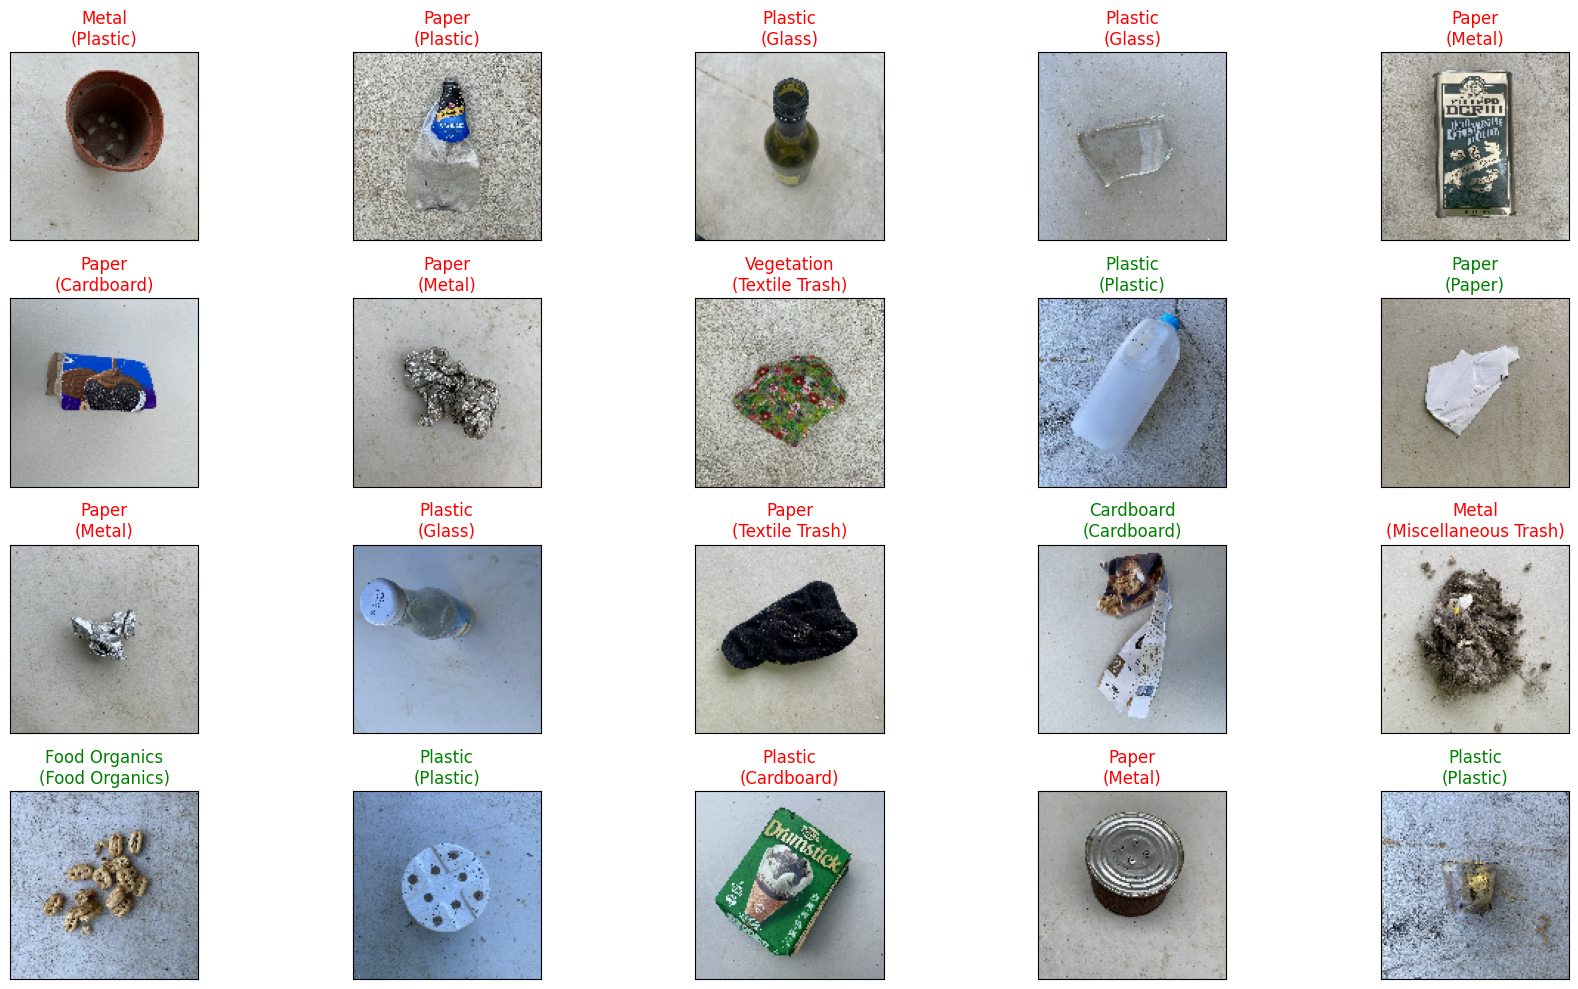

In [12]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [13]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 35.53%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
Vegetation,0.614035,0.795455,0.693069,88.0
Cardboard,0.557377,0.365591,0.441558,93.0
Plastic,0.332248,0.551351,0.414634,185.0
Food Organics,0.410256,0.385542,0.397516,83.0
Paper,0.198606,0.570000,0.294574,100.0
Metal,0.373626,0.215190,0.273092,158.0
Miscellaneous Trash,0.500000,0.060606,0.108108,99.0
Glass,1.000000,0.047619,0.090909,84.0
Textile Trash,0.000000,0.000000,0.000000,64.0
